In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
from utide import solve
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf

In [3]:
from analysis_routines import *
from plotting_routines_xr import *
from harmonic_analysis import *
from wavelet_analysis import *
from processing_routines import datenum_to_epoch
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf
plt.style.use('/home/manu/TFG_repo/notebooks/mplstyles/notebook.mplstyle')

In [4]:
fit_chain = load_SHDR_fit('optimal_server_fit/AGL_20181116_fit_fci.csv')
data_chain = load_time_series_xr('processed/AGL_20181116_chain_xrcompatible.nc')
G005 = pd.read_csv(data_dir / 'SHDR_fit/aux/G05.csv', index_col='date', parse_dates=True)
delta005 = pd.read_csv(data_dir / 'SHDR_fit/aux/delta05_ci.csv', index_col='date', parse_dates=True)

In [5]:
D1_filt1800 = lowpass_filter(fit_chain.D1, data_chain.date, 1/5, 1/1800)
G005_filt1800 = lowpass_filter(G005.x, data_chain.date, 1/5, 1/1800)

hi = period_to_freq(6, 'h')
G005_6h = lowpass_filter(G005.x, data_chain.date, 1/5, hi)
D1_6h = lowpass_filter(fit_chain.D1, data_chain.date, 1/5, hi)

In [6]:
D1_ = fit_chain['D1']
a2_ = fit_chain['a2']
a1_ = fit_chain['a1']
b2_ = fit_chain['b2']
c2_ = fit_chain['c2']

coriolis_frequency = 2*7.2921e-5*np.sin(np.deg2rad(data_chain.lat.data)[0])
coriolis_freq_cps = coriolis_frequency/2/np.pi
coriolis_freq_cpd = coriolis_freq_cps*60*60*24
M2_cpd = 1/12.42061*24
M6_cpd = 1/4.14020*24
M4_cpd = 1/6.210301*24
K1_cpd = 1/23.934470*24
Q1_cpd = 1/28.006223*24
M3_cpd = 1/8.280401*24
M8_cpd = 1/3.105150*24
O1_cpd = 1/1/25.819351*24 # not present in temperature record
Q1_2_cpd = 1/28.006223*24

# Harmoic analysis & Utide
Nota 1: Filtrar M2 en las series de los termistores o de D1 no tiene efectos significativos sobre los demas constituyentes

Nota 2: Filtro lowpass para quitar ruido de altas frecuencias tmapoco tiene efectos significativos en en análisis con UTide 

## Completo

In [6]:
complete_ci = TidalComponentsFit.compute(df_ci, period=[None, None, 6])

In [7]:
complete_ci.clean()

In [11]:
complete_ci.D1

,period,PE,SNR,A,A_ci,g,g_ci
name,,,,,,,
M2,12.420601,5.618951,39.174451,2.928870,0.917180,47.610279,17.941438
K1,23.934470,3.675320,18.264360,2.368754,1.086360,146.534635,26.281745
2Q1,28.006223,2.024010,10.056212,1.757837,1.086470,245.726421,35.412104
L2,12.191620,1.483654,10.344140,1.505008,0.917165,16.728448,34.916092
O1,25.819342,1.074583,5.341629,1.280832,1.086204,266.146244,48.612076


In [7]:
G005_complete = coef_dataframe(G005.x, period=[None, None, 6])

In [8]:
G005_complete.loc['M2']

period     12.420601
PE          1.698386
SNR         7.836402
A           0.000744
A_ci        0.000521
g         252.454779
g_ci       40.099643
Name: M2, dtype: float64

# ESPECTROS GLOBALES CON FFT

In [8]:
freqs_D1, psd_D1, dof_D1 = windowed_spectrum(D1_, 5/60/60/24, 28, 3) #window 42.67
freqs_a2, psd_a2, dof_a2 = windowed_spectrum(a2_, 5/60/60/24, 28, 3) 
freqs_a1, psd_a1, dof_a1 = windowed_spectrum(a1_, 5/60/60/24, 28, 3) 
freqs_b2, psd_b2, dof_b2 = windowed_spectrum(b2_, 5/60/60/24, 28, 3) 
freqs_c2, psd_c2, dof_c2 = windowed_spectrum(c2_, 5/60/60/24, 28, 3) 
freqs_G005, psd_G005, dof_G005 = windowed_spectrum(G005.x, 5/60/60/24, 28, 3) 

In [9]:
freqs_G005c, psd_G005c, dof_G005c = windowed_spectrum(G005.x[:datetime(2019, 2, 15)], 5/60/60/24, 28, 5)
freqs_D1c, psd_D1c, dof_D1c = windowed_spectrum(D1_[:datetime(2019, 2, 15)], 5/60/60/24, 28, 3) #window 42.67
freqs_a2c, psd_a2c, dof_a2c = windowed_spectrum(a2_[:datetime(2019, 2, 15)], 5/60/60/24, 28, 3) 
freqs_a1c, psd_a1c, dof_a1c = windowed_spectrum(a1_[:datetime(2019, 2, 15)], 5/60/60/24, 28, 3) 
freqs_b2c, psd_b2c, dof_b2c = windowed_spectrum(b2_[:datetime(2019, 2, 15)], 5/60/60/24, 28, 3) 
freqs_c2c, psd_c2c, dof_c2c = windowed_spectrum(c2_[:datetime(2019, 2, 15)], 5/60/60/24, 28, 3) 

In [20]:
temp_1 = data_chain.temp[:, 1].data
freqs_temp_1, psd_temp_1, dof_temp_1 = windowed_spectrum(temp_1, 5/60/60/24, 28, 3)

temp_4 = data_chain.temp[:, 4].data
freqs_temp_4, psd_temp_4, dof_temp_4 = windowed_spectrum(temp_4, 5/60/60/24, 28, 3)

temp_7 = data_chain.temp[:, 7].data
freqs_temp_7, psd_temp_7, dof_temp_7 = windowed_spectrum(temp_7, 5/60/60/24, 28, 3)

temp_8 = data_chain.temp[:, 8].data
freqs_temp_8, psd_temp_8, dof_temp_8 = windowed_spectrum(temp_8, 5/60/60/24, 28, 3) 

temp_10 = data_chain.temp[:, 10].data
freqs_temp_10, psd_temp_10, dof_temp_10 = windowed_spectrum(temp_10, 5/60/60/24, 28, 3)

temp_14 = data_chain.temp[:, 14].data
freqs_temp_14, psd_temp_14, dof_temp_14 = windowed_spectrum(temp_14, 5/60/60/24, 28, 3)

### Espectros parámetrod serie completa

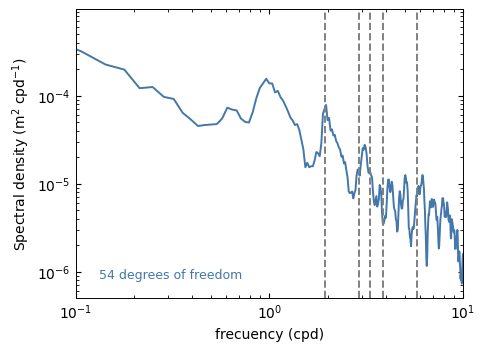

In [40]:
plot_spectrum(freqs_G005, psd_G005, dof_G005, 'cpd', 'm', vlines=[coriolis_freq_cpd + M2_cpd,
                                                               M2_cpd, M4_cpd, M3_cpd, M6_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-7, None))

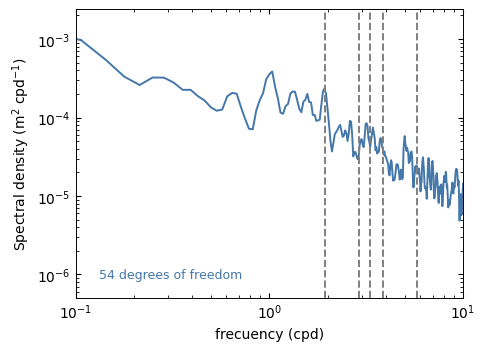

In [12]:
plot_spectrum(freqs_b2, psd_b2, dof_b2, 'cpd', 'm', vlines=[coriolis_freq_cpd + M2_cpd,
                                                               M2_cpd, M4_cpd, M3_cpd, M6_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-7, None))

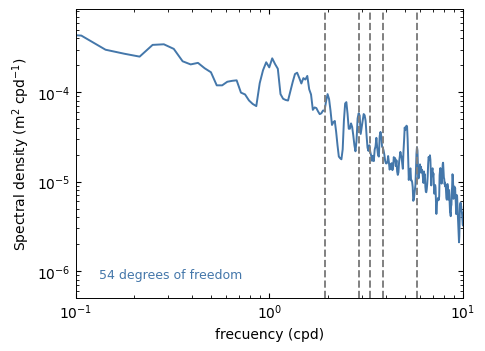

In [13]:
plot_spectrum(freqs_c2, psd_c2, dof_c2, 'cpd', 'm', vlines=[coriolis_freq_cpd + M2_cpd,
                                                               M2_cpd, M4_cpd, M3_cpd, M6_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-7, None))

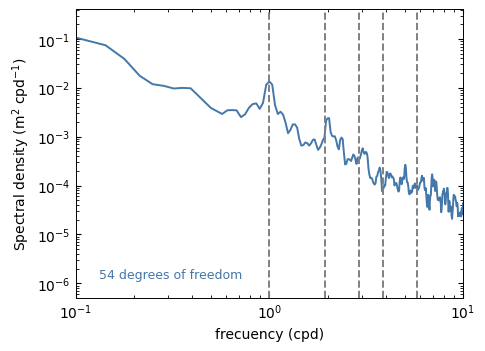

In [15]:
plot_spectrum(freqs_a1, psd_a1, dof_a1, 'cpd', 'm', vlines=[1, M2_cpd, M4_cpd, M6_cpd, M3_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-7, None))

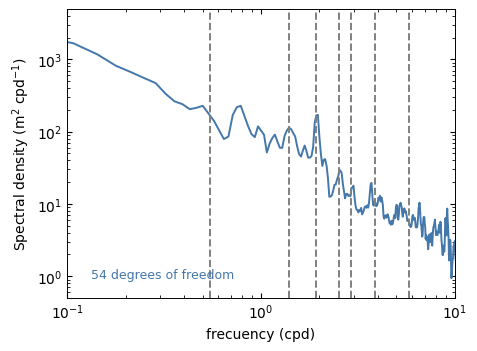

In [29]:
plot_spectrum(freqs_D1, psd_D1, dof_D1, 'cpd', 'm', vlines=[1*coriolis_freq_cpd, M2_cpd, M2_cpd - coriolis_freq_cpd,
                                                            M3_cpd, 1/9.5*24, M6_cpd, M4_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-1,None))

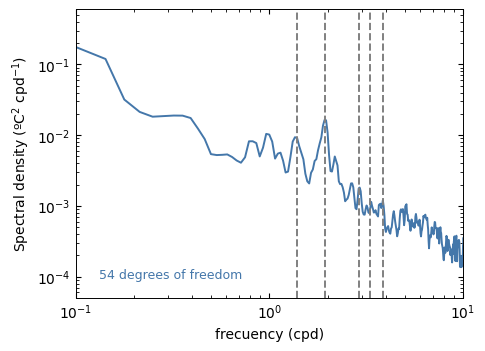

In [53]:
plot_spectrum(freqs_a2, psd_a2, dof_a2, 'cpd', 'ºC', vlines=[1*coriolis_freq_cpd, M2_cpd, M3_cpd, 
                                                             coriolis_freq_cpd + M2_cpd, M4_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-5, None))

### Espectros parámetros hasta 15 feberero

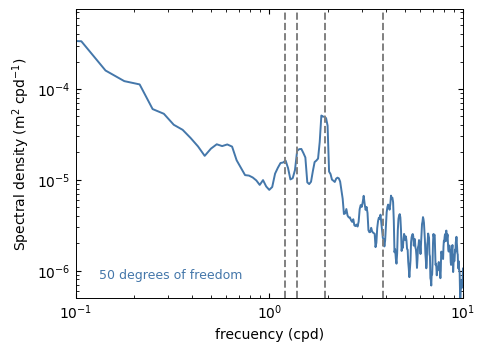

In [13]:
plot_spectrum(freqs_G005c, psd_G005c, dof_G005c, 'cpd', 'm', 
              vlines=[1/20*24, coriolis_freq_cpd, M2_cpd, M4_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-7, None))

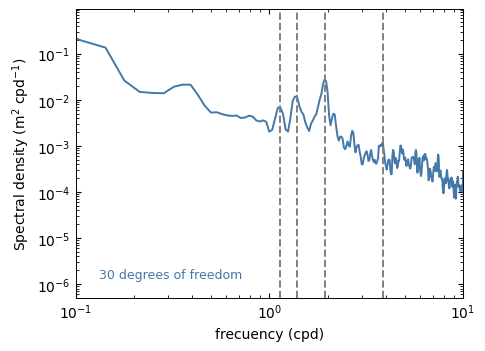

In [15]:
plot_spectrum(freqs_a2c, psd_a2c, dof_a2c, 'cpd', 'm', vlines=[1/21*24, coriolis_freq_cpd, M2_cpd, M4_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-7, None))

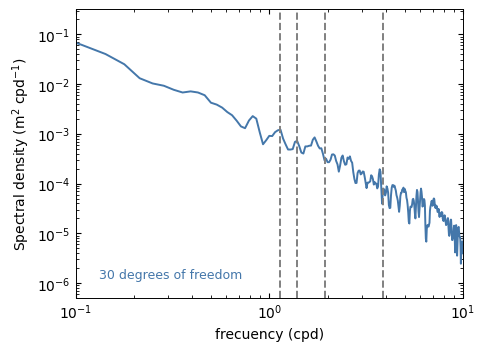

In [16]:
plot_spectrum(freqs_a1c, psd_a1c, dof_a1c, 'cpd', 'm', vlines=[1/21*24, coriolis_freq_cpd, M2_cpd, M4_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-7, None))

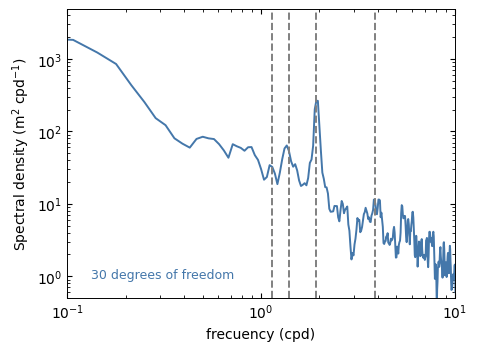

In [17]:
plot_spectrum(freqs_D1c, psd_D1c, dof_D1c, 'cpd', 'm', vlines=[1/21*24, 1*coriolis_freq_cpd, M2_cpd, M4_cpd], 
              xlim=(10**-1, 10**1), ylim=(5*10**-1,None))

### Espectros termistores

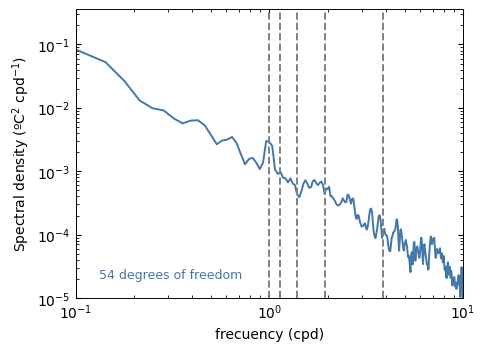

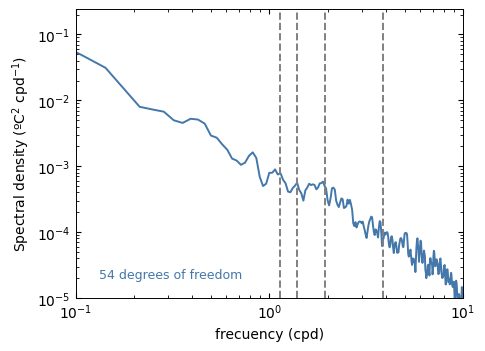

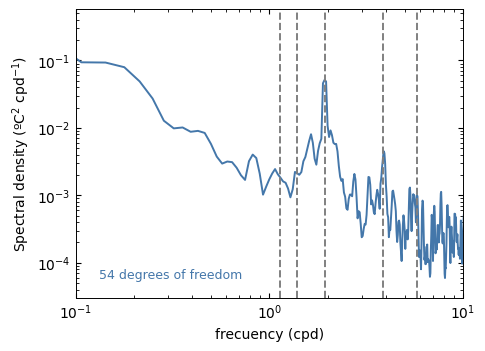

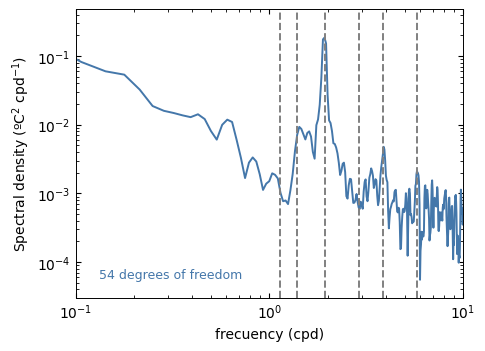

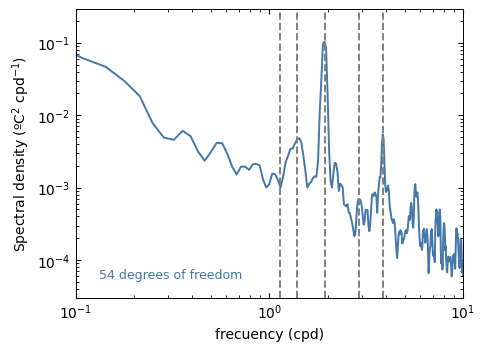

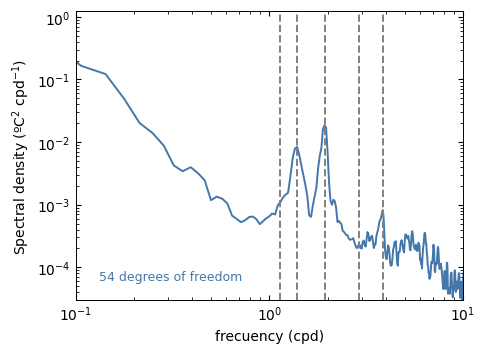

In [21]:
plot_spectrum(freqs_temp_1, psd_temp_1, dof_temp_1, 'cpd', 'ºC', 
              vlines=[1, 1/21*24, 1*coriolis_freq_cpd, M2_cpd, M4_cpd], 
              xlim=(10**-1, 10**1), ylim=(1*10**-5, None))

plot_spectrum(freqs_temp_4, psd_temp_4, dof_temp_4, 'cpd', 'ºC', 
              vlines=[1*coriolis_freq_cpd, 1/21*24, M2_cpd, M4_cpd], 
              xlim=(10**-1, 10**1), ylim=(1*10**-5, None))

plot_spectrum(freqs_temp_7, psd_temp_7, dof_temp_7, 'cpd', 'ºC', 
              vlines=[1*coriolis_freq_cpd, 1/21*24, M2_cpd, M4_cpd, M6_cpd], 
              xlim=(10**-1, 10**1), ylim=(3*10**-5, None))

plot_spectrum(freqs_temp_8, psd_temp_8, dof_temp_8, 'cpd', 'ºC', 
              vlines=[1*coriolis_freq_cpd, 1/21*24, M2_cpd, M4_cpd, M6_cpd, M3_cpd], 
              xlim=(10**-1, 10**1), ylim=(3*10**-5, None))

plot_spectrum(freqs_temp_10, psd_temp_10, dof_temp_10, 'cpd', 'ºC', 
              vlines=[1*coriolis_freq_cpd, 1/21*24, M2_cpd, M4_cpd, M3_cpd], 
              xlim=(10**-1, 10**1), ylim=(3*10**-5, None))

plot_spectrum(freqs_temp_14, psd_temp_14, dof_temp_14, 'cpd', 'ºC', 
              vlines=[1*coriolis_freq_cpd, 1/21*24, M2_cpd, M4_cpd, M3_cpd], 
              xlim=(10**-1, 10**1), ylim=(3*10**-5, None))

### Espectros sin ventanas

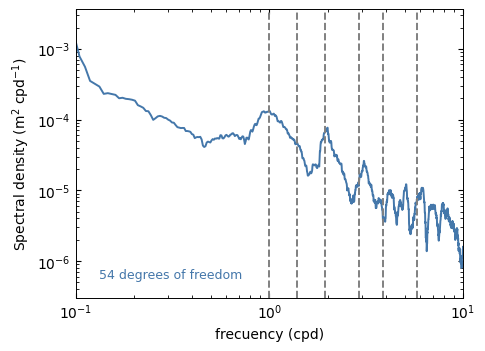

In [289]:
freqs, amplitude, power, psd, dof = spectrum(G05.x.to_numpy(), 5/60/60/24, 27)
plot_spectrum(freqs, psd, dof, 'cpd', 'm', vlines=[1, M2_cpd, M4_cpd, M3_cpd, M6_cpd, coriolis_freq_cpd], 
              xlim=(10**-1, 10**1), ylim=(3*10**-7, None))

In [66]:
low = period_to_freq(26, 'h')
high = period_to_freq(23., 'h')
G005_24bandpass = bandpass_filter(G005.x, data_chain.date, 1/5,  low, high)
D1_24bandpass = bandpass_filter(D1_, data_chain.date, 1/5, low, high)
a1_24bandpass = bandpass_filter(a1_, data_chain.date, 1/5, low, high)

In [23]:
low = period_to_freq(9, 'h')
high = period_to_freq(7, 'h')
G005_8bandpass = bandpass_filter(G005.x, data_chain.date, 1/5,  low, high)
D1_8bandpass = bandpass_filter(D1_, data_chain.date, 1/5, low, high)

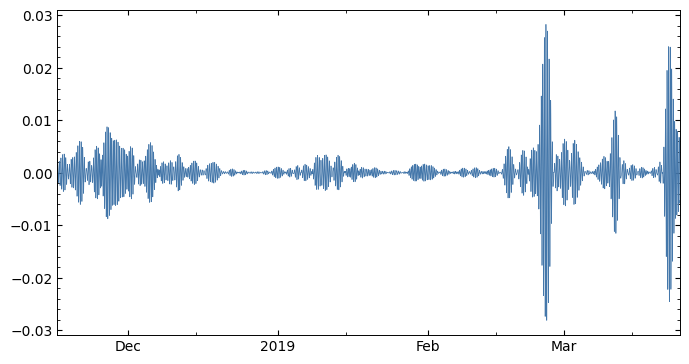

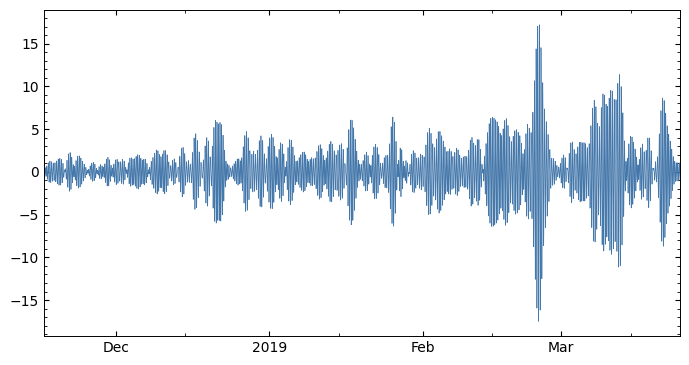

In [65]:
plot_arbitrary_variable(G005_8bandpass, kind='plot', lw=0.5, period=(None, datetime(2019, 3, 25)))
plot_arbitrary_variable(D1_8bandpass, kind='plot', lw=0.5, period=(None, datetime(2019, 3, 25)))

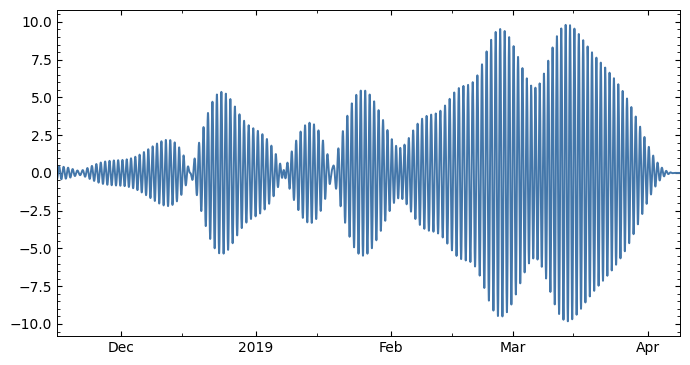

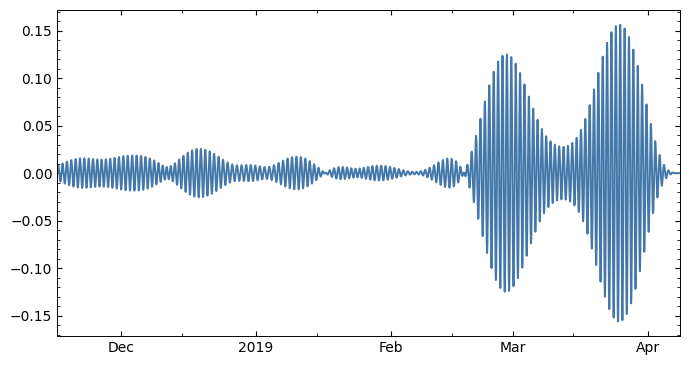

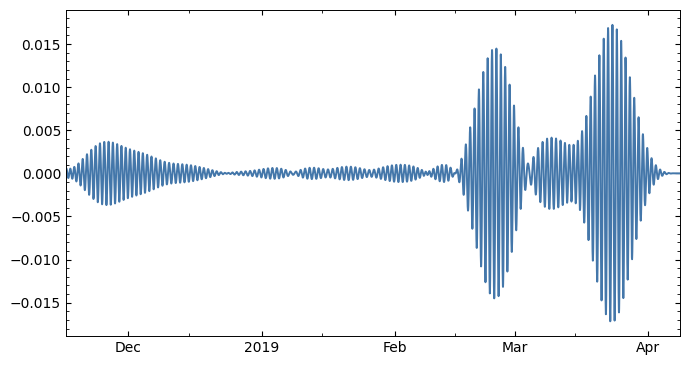

In [68]:
plot_arbitrary_variable(D1_24bandpass, kind='plot')
plot_arbitrary_variable(a1_24bandpass, kind='plot')
plot_arbitrary_variable(G005_24bandpass, kind='plot')


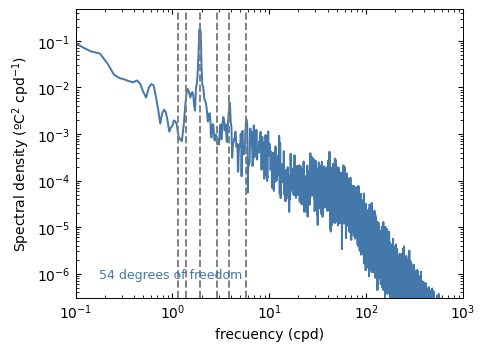

In [23]:
### garret munk
plot_spectrum(freqs_temp_8, psd_temp_8, dof_temp_8, 'cpd', 'ºC', 
              vlines=[1*coriolis_freq_cpd, 1/21*24, M2_cpd, M4_cpd, M6_cpd, M3_cpd], 
              xlim=(10**-1, 10**3), ylim=(3*10**-7, None))

In [56]:
loc = np.where(abs(freqs_temp_8 - 2e1) < 0.0001)[0][0]

In [57]:
loc

559

In [69]:
x = freqs_temp_7[loc:]/24/60/60
y = psd_temp_7[loc:]

In [59]:
coriolis_freq

NameError: name 'coriolis_freq' is not defined

In [84]:
def garret_munk(freqs, E):
    freqs = freqs*2*np.pi
    f = coriolis_freq_cps
    return E*f/freqs/(freqs**2 - f**2)**0.5

from scipy.optimize import curve_fit

In [82]:
popt, pcov = curve_fit(garret_munk, x, y)

In [83]:
popt

array([3.75369871e-07])

In [80]:
np.sqrt(pcov)

array([[3.91778661e-09]])